# Load the Datasets

In [ ]:
%pip install duckdb numpy pandas matplotlib seaborn

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

import duckdb

conn = duckdb.connect("main.db")

In [5]:
file_path = "/workspaces/Delivery-Time-Crisis-Analysis/Datasets"

In [7]:
conn.execute(f"""CREATE OR REPLACE TABLE events 
    AS 
    SELECT * FROM read_csv("{file_path}/ds_blinkit_events.csv")
    """)

conn.execute("SELECT * FROM events LIMIT 3").fetch_df()

,event_id,zone_id,event_type,start_time,end_time
0,EVT00001,106,Rain,2024-01-04 17:00:00,2024-01-04 19:00:00
1,EVT00002,101,Rain,2024-01-04 17:00:00,2024-01-04 19:00:00
2,EVT00003,106,Traffic_Jam,2024-01-09 14:00:00,2024-01-09 15:30:00


In [8]:
conn.execute(f"""CREATE OR REPLACE TABLE orders 
    AS 
    SELECT * FROM read_csv("{file_path}/ds_blinkit_orders.csv")
    """)

conn.execute("SELECT * FROM orders LIMIT 3").fetch_df()

,order_id,zone_id,store_id,order_time,delivery_time_mins,status,cancellation_reason
0,ORD1000000,101,1,2024-01-01 00:47:00,9.40,Delivered,None
1,ORD1000001,101,1,2024-01-01 00:08:00,8.89,Delivered,None
2,ORD1000002,101,3,2024-01-01 00:47:00,9.52,Delivered,None


In [9]:
conn.execute(f"""CREATE OR REPLACE TABLE store_load 
    AS 
    SELECT * FROM read_csv("{file_path}/ds_blinkit_store_load.csv")
    """)

conn.execute("SELECT * FROM store_load LIMIT 3").fetch_df()

,store_id,timestamp,active_riders,orders_in_queue,avg_rider_wait_time
0,1,2024-01-01,11,0,1.01
1,2,2024-01-01,6,3,1.50
2,3,2024-01-01,6,3,0.74


# Exploring the Dataset

In [3]:
conn.execute("""
SELECT
COUNT(*) as orders,
ROUND(AVG(delivery_time_mins), 2) as avg_delivery_mins
FROM orders
WHERE status = 'Delivered'
""").fetch_df()

,orders,avg_delivery_mins
0,106042,9.95


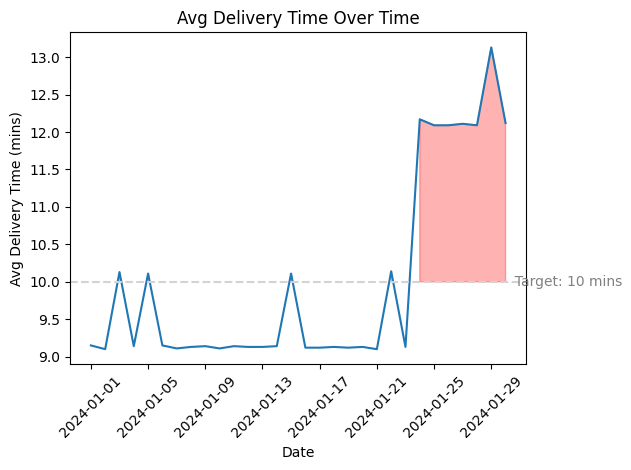

In [4]:
df = conn.execute("""
SELECT
    DATE(order_time) AS date,
    COUNT(*) as orders,
    ROUND(AVG(delivery_time_mins), 2) as avg_delivery_mins
FROM orders
GROUP BY DATE(order_time)
""").fetch_df()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

plt.figure()

# Main line
plt.plot(df['date'], df['avg_delivery_mins'])

# Reference line
plt.axhline(y=10, linestyle='--', color='lightgray')

# Label directly on the line
plt.text(
    df['date'].iloc[-1],   # place near right edge
    10,
    "  Target: 10 mins",
    va='center',
    color='gray'
)

# Shade area above 10 mins
plt.fill_between(
    df['date'],
    df['avg_delivery_mins'],
    10,
    where=(df['avg_delivery_mins'] > 10),
    alpha=0.3,
    color='red'
)

plt.xlabel("Date")
plt.ylabel("Avg Delivery Time (mins)")
plt.title("Avg Delivery Time Over Time")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

*Starting the 24th, we see a spike in the avg delivery time - which has sustained till the end of the month*

In [5]:
conn.execute("""
    WITH period_metrics AS (
    SELECT
        CASE 
            WHEN order_time < '2024-01-24' THEN 'Normal Period'
            ELSE 'Crisis Period'
        END AS time_period,
         
        COUNT(*) AS total_orders,
        COUNT(*) * 1.0 / COUNT(DISTINCT DATE(order_time)) AS orders_per_day,
        ROUND(AVG(delivery_time_mins), 2) AS avg_delivery_time,
        ROUND(AVG(CASE WHEN status = 'Cancelled' THEN 1.0 ELSE 0.0 END) * 100, 2) AS cancellation_rate_pct,
        COUNT(CASE WHEN cancellation_reason = 'Too long' THEN 1 END) AS cancelled_too_long
    FROM orders
    GROUP BY 1
),

comparison AS (
    SELECT
        'Crisis vs Normal (% Change)' AS time_period,
        
        '-' AS total_orders,
        
        ROUND(
            (c.orders_per_day - n.orders_per_day) * 100.0 / n.orders_per_day, 2
        ) AS orders_per_day,
        
        ROUND(
            (c.avg_delivery_time - n.avg_delivery_time) * 100.0 / n.avg_delivery_time, 2
        ) AS avg_delivery_time,
        
        ROUND(
            (c.cancellation_rate_pct - n.cancellation_rate_pct) * 100.0 / n.cancellation_rate_pct, 2
        ) AS cancellation_rate_pct,
        
        ROUND(
            (c.cancelled_too_long - n.cancelled_too_long) * 100.0 / n.cancelled_too_long, 2
        ) AS cancelled_too_long
        
    FROM period_metrics n
    JOIN period_metrics c
        ON n.time_period = 'Normal Period'
       AND c.time_period = 'Crisis Period'
)

SELECT * FROM period_metrics
UNION ALL
SELECT * FROM comparison;

""").fetch_df()

,time_period,total_orders,orders_per_day,avg_delivery_time,cancellation_rate_pct,cancelled_too_long
0,Crisis Period,25733,3676.142857,12.24,7.92,1856.00
1,Normal Period,83965,3650.652174,9.29,1.93,533.00
2,Crisis vs Normal (% Change),-,0.700000,31.75,310.36,248.22


*Cancellations increased massively in the Crisis period*

In [9]:
conn.execute("""
    WITH period_metrics AS (
    SELECT
        CASE 
            WHEN order_time < '2024-01-24' THEN 'Normal Period'
            ELSE 'Crisis Period'
        END AS time_period,
         
        COUNT(*) AS total_orders,
        COUNT(*) * 1.0 / COUNT(DISTINCT DATE(order_time)) AS orders_per_day,
        ROUND(AVG(delivery_time_mins), 2) AS avg_delivery_time,
        ROUND(AVG(CASE WHEN status = 'Cancelled' THEN 1.0 ELSE 0.0 END) * 100, 2) AS cancellation_rate_pct,
        COUNT(CASE WHEN cancellation_reason = 'Too long' THEN 1 END) AS cancelled_too_long
    FROM orders
    GROUP BY 1
)
    SELECT
        time_period,
        cancelled_too_long * 350.0 AS 'Cancelled Orders Value (₹)'
    FROM period_metrics
    """).fetch_df()

,time_period,Cancelled Orders Value (₹)
0,Crisis Period,649600.0
1,Normal Period,186550.0


*Assuming an average basket size of ₹350, the company incurred an estimated revenue loss of nearly ₹6.5 lakhs due to cancellations caused by delayed order fulfillment.*

# Testing the Hypothesis

## Hypothesis 1 - Delays due to Rain

In [18]:
conn.execute("""
SELECT
    e.zone_id,
    e.event_type,
    DATE(e.start_time) AS date,
    COUNT(o.*) AS total_orders,
    ROUND(AVG(o.delivery_time_mins), 2) as avg_delivery_time
FROM events e
JOIN orders o
ON o.zone_id = e.zone_id AND o.order_time >= e.start_time AND o.order_time <= end_time 
GROUP BY e.zone_id, e.event_type, DATE(e.start_time)
ORDER BY DATE(e.start_time)
""").fetch_df()

,zone_id,event_type,date,total_orders,avg_delivery_time
0,106,Rain,2024-01-04,60,9.11
1,101,Rain,2024-01-04,120,9.33
2,106,Traffic_Jam,2024-01-09,21,9.15
3,104,Rain,2024-01-10,60,9.02
4,102,Traffic_Jam,2024-01-13,87,8.96
5,102,Traffic_Jam,2024-01-27,78,12.49
6,105,Traffic_Jam,2024-01-28,79,12.62


In [19]:
conn.execute("""
SELECT 
    DATE(start_time) as rain_date,
    COUNT(DISTINCT zone_id) as zones_affected,
    event_type
FROM events
WHERE event_type = 'Rain'
    AND start_time >= '2024-01-24'
GROUP BY 1, 3
ORDER BY 1; 
""").fetch_df()

,rain_date,zones_affected,event_type


*External events like Rain and Traffic Jam are not limited to the crisis period of 24th - 30th, hence we can safely assume that the delays were not caused by rain or traffic jam*

## Hypothesis 2 - Lack of Riders

In [22]:
conn.execute(""" 
SELECT 
    CASE 
        WHEN timestamp < '2024-01-24' THEN 'Normal'
        ELSE 'Crisis'
    END AS time_period,
    ROUND(AVG(active_riders), 1) as avg_active_riders,
    ROUND(MIN(active_riders), 1) as min_riders,
    ROUND(MAX(active_riders), 1) as max_riders
FROM store_load
GROUP BY 1;
""").fetch_df()

,time_period,avg_active_riders,min_riders,max_riders
0,Crisis,8.7,3,17
1,Normal,8.7,3,17


*No. of active riders were same during the crisis period and the normal period - then can it be related to a store inefficiency?*

In [ ]:
conn.execute(""" 
WITH base AS (
    SELECT 
        store_id,
        CASE 
            WHEN timestamp < '2024-01-24' THEN 'Normal'
            ELSE 'Crisis'
        END AS time_period,
        ROUND(AVG(active_riders), 1) as avg_riders,
        ROUND(AVG(orders_in_queue), 1) as avg_orders_queued,
        ROUND(AVG(orders_in_queue::float / NULLIF(active_riders, 0)), 2) as queue_per_rider,
        ROUND(AVG(avg_rider_wait_time), 2) as avg_rider_wait_mins
    FROM store_load
    GROUP BY 1, 2
),

pivoted AS (
    SELECT
        store_id,

        MAX(CASE WHEN time_period = 'Normal' THEN avg_riders END) AS normal_avg_riders,
        MAX(CASE WHEN time_period = 'Crisis' THEN avg_riders END) AS crisis_avg_riders,

        MAX(CASE WHEN time_period = 'Normal' THEN avg_orders_queued END) AS normal_avg_orders_queued,
        MAX(CASE WHEN time_period = 'Crisis' THEN avg_orders_queued END) AS crisis_avg_orders_queued,

        MAX(CASE WHEN time_period = 'Normal' THEN queue_per_rider END) AS normal_queue_per_rider,
        MAX(CASE WHEN time_period = 'Crisis' THEN queue_per_rider END) AS crisis_queue_per_rider,

        MAX(CASE WHEN time_period = 'Normal' THEN avg_rider_wait_mins END) AS normal_avg_wait,
        MAX(CASE WHEN time_period = 'Crisis' THEN avg_rider_wait_mins END) AS crisis_avg_wait

    FROM base
    GROUP BY store_id
)

SELECT
    *,

    -- % Change Calculations
    ROUND((crisis_avg_riders - normal_avg_riders) * 100.0 / NULLIF(normal_avg_riders, 0), 2) AS pct_change_riders,
    
    ROUND((crisis_avg_orders_queued - normal_avg_orders_queued) * 100.0 / NULLIF(normal_avg_orders_queued, 0), 2) AS pct_change_orders_queued,
    
    ROUND((crisis_queue_per_rider - normal_queue_per_rider) * 100.0 / NULLIF(normal_queue_per_rider, 0), 2) AS pct_change_queue_per_rider,
    
    ROUND((crisis_avg_wait - normal_avg_wait) * 100.0 / NULLIF(normal_avg_wait, 0), 2) AS pct_change_wait

FROM pivoted
ORDER BY store_id;

""").fetch_df()

,store_id,normal_avg_riders,crisis_avg_riders,normal_avg_orders_queued,crisis_avg_orders_queued,normal_queue_per_rider,crisis_queue_per_rider,normal_avg_wait,crisis_avg_wait,pct_change_riders,pct_change_orders_queued,pct_change_queue_per_rider,pct_change_wait
0,1,12.6,12.6,1.5,11.7,0.12,0.93,1.00,4.73,0.00,680.00,675.00,373.00
1,2,8.5,8.4,1.5,11.7,0.18,1.43,0.99,4.78,-1.18,680.00,694.44,382.83
2,3,5.3,5.2,1.5,3.5,0.31,0.74,1.01,2.26,-1.89,133.33,138.71,123.76
3,4,12.7,12.6,1.5,11.4,0.12,0.91,1.01,4.72,-0.79,660.00,658.33,367.33
4,5,8.4,8.4,1.5,3.5,0.18,0.43,1.01,2.25,0.00,133.33,138.89,122.77
5,6,8.4,8.4,1.5,3.5,0.18,0.43,1.00,2.24,0.00,133.33,138.89,124.00
6,7,5.2,5.2,1.5,3.6,0.31,0.74,1.00,2.23,0.00,140.00,138.71,123.00
7,8,8.4,8.4,1.5,3.5,0.18,0.43,1.00,2.24,0.00,133.33,138.89,124.00
8,9,12.7,12.6,1.5,11.7,0.12,0.94,1.00,4.74,-0.79,680.00,683.33,374.00
9,10,8.4,8.4,1.4,3.6,0.18,0.44,1.00,2.25,0.00,157.14,144.44,125.00


*Stores - 1, 2, 4, 9 seem to be the bottleneck - since the average orders queued are way more than the normal period average*

*I reject hypothesis 2 as well. The no. of riders remains same during the crisis period.*

This opens doors to new investigation paths - based on my finding, I will focus on store and zone level metrics to confirm that the issue is limited to particular zones

## Hypothesis 3 - The delivery time spike is limited to only a few zones & stores

In [16]:
conn.execute(""" 
        SELECT
             zone_id,
             COUNT(*) AS total_orders,
             ROUND(AVG(delivery_time_mins), 2) as avg_delivery_time,
             ROUND(AVG(CASE WHEN status = 'Cancelled' THEN 1.0 ELSE 0.0 END) * 100, 2) as cancellation_rate_pct,
             COUNT(CASE WHEN cancellation_reason = 'Too long' THEN 1 END) as cancelled_too_long
        FROM orders
             WHERE order_time >= '2024-01-24'
             GROUP BY zone_id
             ORDER BY avg_delivery_time DESC

""").fetch_df()

,zone_id,total_orders,avg_delivery_time,cancellation_rate_pct,cancelled_too_long
0,101,5527,13.42,11.33,611
1,102,5527,12.78,9.44,483
2,105,5527,12.76,8.97,471
3,103,2733,10.98,4.21,83
4,106,2733,10.98,4.21,87
5,107,953,10.98,4.30,28
6,104,2733,10.96,4.54,93


In [17]:
conn.execute(""" 
        SELECT
             zone_id,
             AVG(CASE WHEN order_time < '2024-01-24' THEN delivery_time_mins END) as normal_avg,
             AVG(CASE WHEN order_time >= '2024-01-24' THEN delivery_time_mins END) as crisis_avg,
             ROUND(
                AVG(CASE WHEN order_time >= '2024-01-24' THEN delivery_time_mins END) - 
                AVG(CASE WHEN order_time < '2024-01-24' THEN delivery_time_mins END), 2) as degradation_mins
        FROM orders
             GROUP BY zone_id
             ORDER BY degradation_mins DESC

""").fetch_df()

,zone_id,normal_avg,crisis_avg,degradation_mins
0,101,9.284378,13.424989,4.14
1,102,9.286222,12.779129,3.49
2,105,9.294642,12.758708,3.46
3,103,9.282151,10.983235,1.70
4,106,9.280431,10.978251,1.70
5,104,9.286871,10.956424,1.67
6,107,9.305881,10.980099,1.67


*Zones 101, 102, 105 - were the most affected during this crisis*

In [19]:
conn.execute(""" 
        SELECT
             zone_id,
             store_id,
             COUNT(*) AS total_orders,
             ROUND(AVG(delivery_time_mins), 2) as avg_delivery_time,
             ROUND(AVG(CASE WHEN status = 'Cancelled' THEN 1.0 ELSE 0.0 END) * 100, 2) as cancellation_rate_pct,
             COUNT(CASE WHEN cancellation_reason = 'Too long' THEN 1 END) as cancelled_too_long
        FROM orders
             WHERE order_time >= '2024-01-24'
             GROUP BY zone_id, store_id
             ORDER BY avg_delivery_time DESC, zone_id

""").fetch_df()

,zone_id,store_id,total_orders,avg_delivery_time,cancellation_rate_pct,cancelled_too_long
0,105,9,2775,14.75,14.20,394
1,101,1,1917,14.72,14.08,269
2,102,4,2823,14.71,14.35,403
3,101,2,1888,14.66,15.63,295
4,103,6,1389,10.99,4.54,44
5,102,5,2704,10.98,4.33,80
6,106,11,2733,10.98,4.21,87
7,107,12,953,10.98,4.30,28
8,103,7,1344,10.97,3.87,39
9,105,10,2752,10.97,3.71,77


In [19]:
conn.execute(""" 
SELECT 
    store_id,
    ROUND(AVG(active_riders), 1) as avg_riders,
    ROUND(AVG(orders_in_queue), 1) as avg_orders_queued,
    ROUND(MAX(orders_in_queue), 0) as max_queue_size,
    ROUND(AVG(avg_rider_wait_time), 2) as avg_rider_wait_mins,
    ROUND(MAX(avg_rider_wait_time), 2) as max_rider_wait_mins
FROM store_load
    WHERE timestamp >= '2024-01-24'
    GROUP BY 1
    ORDER BY avg_orders_queued DESC, store_id;
""").fetch_df()

,store_id,avg_riders,avg_orders_queued,max_queue_size,avg_rider_wait_mins,max_rider_wait_mins
0,1,12.6,11.7,23,4.73,5.98
1,2,8.4,11.7,23,4.78,6.00
2,9,12.6,11.7,23,4.74,5.99
3,4,12.6,11.4,23,4.72,6.00
4,7,5.2,3.6,5,2.23,3.00
5,10,8.4,3.6,5,2.25,3.00
6,3,5.2,3.5,5,2.26,3.00
7,5,8.4,3.5,5,2.25,3.00
8,6,8.4,3.5,5,2.24,2.99
9,8,8.4,3.5,5,2.24,3.00


In [27]:
conn.execute(""" 
        SELECT
             CASE WHEN store_id IN (1,2,4,9) THEN 'Bottleneck Stores'
             ELSE 'Rest of the stores' END AS store_type,
             CASE 
                    WHEN order_time < '2024-01-24' THEN 'Normal'
                    ELSE 'Crisis'
             END AS time_period,
             COUNT(*) AS total_orders,
             ROUND((COUNT(*)*1.0) / COUNT(DISTINCT DATE(order_time)), 0) AS orders_per_day,
             ROUND(AVG(delivery_time_mins), 2) as avg_delivery_time,
             ROUND(AVG(CASE WHEN status = 'Cancelled' THEN 1.0 ELSE 0.0 END) * 100, 2) as cancellation_rate_pct,
             COUNT(CASE WHEN cancellation_reason = 'Too long' THEN 1 END) as cancelled_too_long
        FROM orders
             GROUP BY 1, 2
             ORDER BY 1

""").fetch_df()

,store_type,time_period,total_orders,orders_per_day,avg_delivery_time,cancellation_rate_pct,cancelled_too_long
0,Bottleneck Stores,Crisis,9403,1343.0,14.71,14.51,1361
1,Bottleneck Stores,Normal,30005,1305.0,9.29,1.95,215
2,Rest of the stores,Crisis,16330,2333.0,10.97,4.13,495
3,Rest of the stores,Normal,53960,2346.0,9.29,1.91,318


*Orders per day remained nearly same during and before the crisis period - this rules out the hypothesis that there was a demand surge in this time period*

*Now that the we know which stores to focus on - let's break it down by the hour of the day*

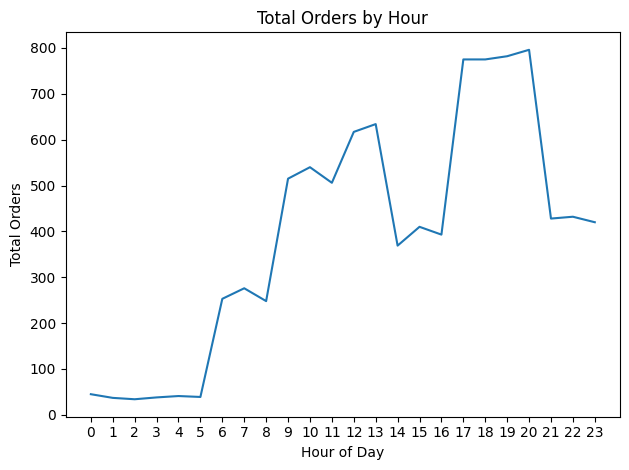

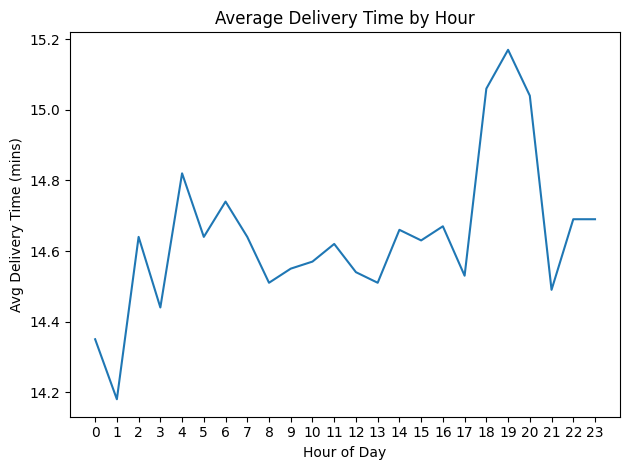

In [24]:
df = conn.execute("""
    SELECT
        EXTRACT('hour' FROM order_time) AS hour, 
        COUNT(*) AS total_orders,
        ROUND(AVG(delivery_time_mins), 2) AS avg_delivery_time
    FROM orders
    WHERE order_time >= '2024-01-24' 
      AND store_id IN (1,2,4,9)
    GROUP BY 1
    ORDER BY hour
""").fetch_df()

# Ensure hour is sorted properly
df = df.sort_values("hour")

# ---- Chart 1: Total Orders by Hour ----
plt.figure()
plt.plot(df["hour"], df["total_orders"])
plt.xlabel("Hour of Day")
plt.ylabel("Total Orders")
plt.title("Total Orders by Hour")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# ---- Chart 2: Average Delivery Time by Hour ----
plt.figure()
plt.plot(df["hour"], df["avg_delivery_time"])
plt.xlabel("Hour of Day")
plt.ylabel("Avg Delivery Time (mins)")
plt.title("Average Delivery Time by Hour")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


*Even at low order volume hours (12AM to 5AM), avg. delivery time is more than 14+ minutes. This rules out "it's just peak hours overloading the system" as an explanation - the inefficiency is constant, not time-dependent*

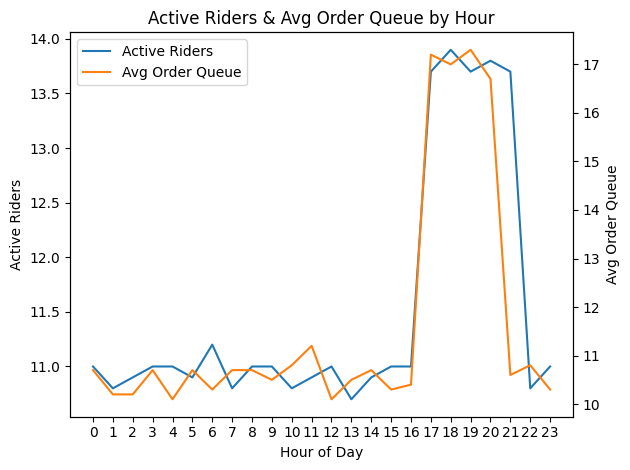

In [27]:
df = conn.execute(""" 
        SELECT
            EXTRACT(HOUR FROM timestamp) AS hour, 
            ROUND(AVG(active_riders), 1) as avg_riders,
            ROUND(AVG(orders_in_queue), 1) as avg_queue
        FROM store_load
             WHERE timestamp >= '2024-01-24' AND store_id IN (1,2,4,9)
             GROUP BY hour
             ORDER BY hour

""").fetch_df()

fig, ax1 = plt.subplots()

# Left axis — Active Riders
line1, = ax1.plot(df["hour"], df["avg_riders"], color="tab:blue")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Active Riders")
ax1.set_xticks(range(0, 24))

# Right axis — Avg Order Queue
ax2 = ax1.twinx()
line2, = ax2.plot(df["hour"], df["avg_queue"], color="tab:orange")
ax2.set_ylabel("Avg Order Queue")

# Combined legend
lines = [line1, line2]
labels = ["Active Riders", "Avg Order Queue"]
ax1.legend(lines, labels, loc="upper left")

plt.title("Active Riders & Avg Order Queue by Hour")
plt.tight_layout()
plt.show()

*Even during the peak order hours the no. of active riders matches the order queue - this suggests that there could be an issue with either assigning riders to orders*

In [7]:
conn.execute("""
        WITH store_load_orders AS (
            SELECT 
                o.store_id,
                o.order_time,
                s.timestamp,
                o.delivery_time_mins,
                s.active_riders,
                s.orders_in_queue,
                s.avg_rider_wait_time,
                -- get the latest store snapshot
                ROW_NUMBER() OVER (
                    PARTITION BY o.order_id
                    ORDER BY s.timestamp DESC
                ) AS rn 
            FROM orders o
            LEFT JOIN store_load s
                ON o.store_id = s.store_id
                AND s.timestamp BETWEEN o.order_time - INTERVAL 15 MINUTE AND o.order_time
            WHERE o.store_id IN (1,2,4,9)
        
        )
        SELECT 
            store_id,
            COUNT(*) AS total_orders,
            ROUND(AVG(delivery_time_mins), 2) AS avg_delivery_time,
            ROUND(AVG(orders_in_queue), 1) AS avg_orders_in_queue,
            ROUND(AVG(active_riders), 1) AS avg_active_riders,
            ROUND(AVG(avg_rider_wait_time), 2) AS avg_rider_wait
        FROM store_load_orders
        WHERE order_time >= '2024-01-24' AND rn = 1
        GROUP BY 1
        ORDER BY 3 DESC

""").fetch_df()

,store_id,total_orders,avg_delivery_time,avg_orders_in_queue,avg_active_riders,avg_rider_wait
0,9,2775,14.75,12.9,13.0,4.77
1,1,1917,14.72,13.0,13.1,4.72
2,4,2823,14.71,12.5,13.1,4.70
3,2,1888,14.66,12.7,8.8,4.81


*We can confirm that stores 1, 2, 4 & 9 are causing the spike in the delivery times*

**Root Issue**
- The spike in delivery time is not caused due to low rider availability or external events like heavy rainfall
- The issue is limited to 3 zones (101 (stores 1,2), 102 (store 4) & 105 (store 9))

- **Orders are packed and sitting, riders are standing idle - and they're not being connected.**

**Suggested Fix**
- We need to optimize the dispatch algorithm, focusing on the four bottleneck stores
- The existing riders are sufficient, they're just not being matched to orders efficiently.